In [1]:
import sys
import glob
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from Src import PreprocessingPipeline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
import os
import math

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prep_pipeline_func = PreprocessingPipeline(target_size=(224, 224, 3), is_gray=False)

In [4]:
BASE_PATH = '..\\'

ASSETS_PATH = os.path.join(BASE_PATH, 'Assets')
DATASET_PATH = os.path.join(ASSETS_PATH, 'Datasets', 'SIBI dataset')
TRAINING_PATH = os.path.join(DATASET_PATH, 'Train', '*', '*')


In [5]:
_class_paths = glob.glob(os.path.join(DATASET_PATH, 'Train', '*'))
CLASSES_LIST = sorted([os.path.basename(label) for label in _class_paths])

In [6]:
images_path_tf_data_train = tf.data.Dataset.list_files(TRAINING_PATH, shuffle=False)

In [7]:
for file in images_path_tf_data_train.take(1):
    split_text=tf.strings.split(file, sep=os.path.sep)
    for idx, value in enumerate(split_text):
        print(f"{idx} -> {value}")

0 -> b'..'
1 -> b'Assets'
2 -> b'Datasets'
3 -> b'SIBI dataset'
4 -> b'Train'
5 -> b'A'
6 -> b'image_A_(1723068076.1335173).jpg'


In [8]:
label_idx_from_path=5

images_tf_data_train = images_path_tf_data_train.map(
    map_func=lambda image_path: 
        prep_pipeline_func.convert_path_to_img_tf_data_train(
            image_path=image_path, 
            label_idx_from_path=label_idx_from_path,
        ),
    num_parallel_calls=tf.data.AUTOTUNE
)

images_tf_data_cached = images_tf_data_train.cache()

In [9]:
for image, label in images_tf_data_cached.skip(305).take(1):
    print(f"{'Check Train Data'.center(10, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    label: {label}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

Check Train Data
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.0

    label: b'B'
    label-shape: ()
    image-type: <dtype: 'string'>


In [10]:
images_tf_data_ohe = images_tf_data_cached.map(lambda image, label: prep_pipeline_func.one_hot_encode(image, label, CLASSES_LIST))
images_tf_data_ohe_cache = images_tf_data_ohe.cache()

In [11]:
# Print information about the cached dataset and the number of data points
print(f'info data: {images_tf_data_ohe_cache}')
print(f'number of data: {len(images_tf_data_ohe_cache)}')

info data: <CacheDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
number of data: 5200


In [89]:
# Menampilkan contoh data yang telah diubah
for image, label in images_tf_data_ohe_cache.skip(305).take(1):
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


In [13]:
class TFToTorchDataset(Dataset):
    def __init__(self, tf_dataset):
        self.tf_dataset = tf_dataset
        
    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        # Convert the index to a TensorFlow slice to efficiently get a single element
        for feature, label in self.tf_dataset.skip(idx).take(1):
            feature = torch.tensor(feature.numpy())
            label = torch.tensor(label.numpy())
            return feature, label
        raise IndexError
    
class TorchToTFDataset:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __getitem__(self, idx):
        feature, label = self.dataloader[idx]
        return feature.numpy(), label.numpy()

    def __len__(self):
        return len(self.dataloader)
            
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [14]:
# Convert to PyTorch Dataset
torch_data = TFToTorchDataset(images_tf_data_ohe_cache)

In [15]:
len(torch_data)

5200

In [16]:
feature0, label0 = torch_data[0]
feature0.max(), feature0.min()

(tensor(1.), tensor(0.))

In [62]:
# Define output signature dynamically using a sample batch
feature, label = torch_data[0]
feature_shape = feature.shape
label_shape = label.shape

feature_shape, label_shape

(torch.Size([224, 224, 3]), torch.Size([26]))

In [76]:
# Wrap the PyTorch DataLoader in the wrapper class
wrapper = TorchToTFDataset(torch_data)

In [77]:
len(wrapper)

5200

In [86]:
# Create a TensorFlow dataset from the generator
output_signature = (
    tf.TensorSpec(shape=(feature_shape)),
    tf.TensorSpec(shape=(label_shape))
)

tf_data = tf.data.Dataset.from_generator(
    wrapper,
    output_signature=output_signature
)

In [87]:
tf_data

<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>

In [88]:
for image, label in tf_data.take(1):
    print(label)

tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


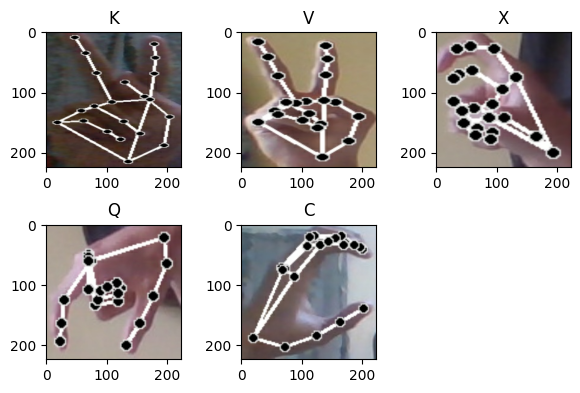

In [19]:
figsize_per_image = (2,2)
n_samples = 5
n_samples_list = np.random.randint(0, len(torch_data), size=n_samples)

# Calculate the number of rows and columns needed
num_columns = math.ceil(math.sqrt(n_samples))
num_rows = math.ceil(n_samples / num_columns)
figsize = (num_columns * figsize_per_image[0], num_rows * figsize_per_image[1])
plt.figure(figsize=figsize)

for axis, index in enumerate(n_samples_list):
    image, label = torch_data[index]

    plt.subplot(num_rows, num_columns, axis + 1)
    plt.imshow(image, cmap='gray')
    plt.title(CLASSES_LIST[label.argmax()])

plt.tight_layout()
plt.show()

In [351]:
dataloader = DataLoader(torch_data, batch_size=1, shuffle=True)

In [324]:
# image, label = torch_data[0]
# plt.imshow(image)
# plt.title(CLASSES_LIST[label.argmax()])
# plt.show()

n_samples = 5
for index, (image, label) in enumerate(dataloader, 1):
    if index >= 5:
        break
    
    print(label)

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
